# Dogs in Vienna. Part 1: Open Data Analysis Tutorial
This is a sample script showing how an open data datasets can be analysed and demonstrated using [Jupiter Notebooks](http://jupyter.org). We take the dog statistics data in Vienna as a sample use case to demonstrate common approaches to analysing open data. Similar examples can be found on [Kaggle web-site](https://www.kaggle.com/kernels).

## Open Data Story
It is useful to define a set of possible research questions that define the goal of the data study and refine them along the way since the availablity of data suggests possible ways to combine and explore it.

### Research Questions
1. How many dogs are there in Vienna?
2. Which dogs do Viennese people like the most?
3. Where should I live if I do not like dogs?
4. What is the dog situation in my district?

## Get the Data
We described how to load and preprocess the dataset in the [previous post](). It is often not that trivial as it may seem and involves a lot of data wrangling and debugging in order to find and eliminate possible errors or inconsistences in the dataset. 

This step should not be underestimated since it defines the final result of our data analysis.
Remember: "Garbage in,  garbage out!"

In [10]:
# Load libraries
import pandas as pd # CSV file processing
import numpy as np # vector and matrix manipulation

# Load the csv file from the open data portal
# dataset description: https://www.data.gv.at/katalog/dataset/stadt-wien_anzahlderhundeprobezirkderstadtwien/resource/b8d97349-c993-486d-b273-362e0524f98c
data_path = 'https://www.wien.gv.at/finanzen/ogd/hunde-wien.csv'
# Look up the row file and specify the dataset format, e.g. delimiters
data = pd.read_csv(data_path, delimiter=';', skiprows=1, thousands=',', encoding='latin-1')

# Correct individual values in the dataset
data.loc[1914, 'Anzahl'] = 1510
data.loc[5347, 'Anzahl'] = 2460

# Carefully select the string separator, including spaces!
separate_breeds = data['Dog Breed'].str.split(' / ', expand=True)
separate_breeds.columns = ["Breed_1", "Breed_2"]
data = pd.concat([data, separate_breeds], axis=1)

# Correct encoding for special characters in german alphabet
def to_utf(x):
    return x.encode('latin-1').decode('utf8') if isinstance(x, str) else x   
data = data.applymap(to_utf)

# Aggregate
data = data.groupby(['DISTRICT_CODE', 'Breed_1'])['Anzahl'].aggregate(np.sum).reset_index()
data.columns = ["District", "Dog Breed", "Dog Count"]

# Check the top of the table to make sure the dataset is loaded correctly 
data.head()

,District,Dog Breed,Dog Count
0,90100,Afghanischer Windhund,1
1,90100,Amerikanischer Pit-Bullterrier,1
2,90100,Amerikanischer Staffordshire-Terrier,5
3,90100,Australian Shepherd Dog,3
4,90100,Australian Terrier,1


In [11]:
data.shape

(3463, 3)

Our dataset contains 3463 rows and 3 columns.

The district codes range from 90100 to 92300 indicating the 23 districts of Vienna (Wiener Bezirke).

Now the data is ready to be analysed!

## Analyse the Data
### 1. How many dogs live in Vienna?

This question is easy to answer using simple column statistics.

In [12]:
sum(data['Dog Count'])

55929

Almost 56 thousand dogs are registered in Vienna.

### 2. Which dog breeds are the most popular in Vienna?

Lets have a look at our dataset closer.

In [13]:
# Check the top counts
sorted_count = data.sort_values(['Dog Count'], ascending=False)
sorted_count.head()

,District,Dog Breed,Dog Count
3251,92200,Unbekannt,2460
3025,92100,Unbekannt,2066
1244,91000,Unbekannt,1510
3447,92300,Unbekannt,1215
1412,91100,Unbekannt,1029


Most of the dog breeds is unfortunately unknown (Unbekannt). It is not clear though, whether we do not know the breed of a dog or they do not know their breed themselves.

Let's exclude the unknown and check how many different breeds we have in total.

In [14]:
# Filter out specific rows
filtered_dogs = sorted_count.loc[data['Dog Breed']!='Unbekannt']
# Check unique values in one of the columns
unique_breeds = filtered_dogs['Dog Breed'].unique()
len(unique_breeds)

320

We have 320 different dog breeds in Vienna. How cool is that!

By aggregating over districts we obtain a rating for the most popular dog breeds in whole Vienna:

[<matplotlib.text.Text at 0x1148c9048>, <matplotlib.text.Text at 0x114da7630>]

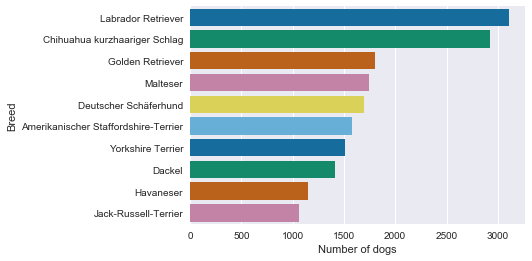

In [20]:
breeds = filtered_dogs.groupby('Dog Breed')['Dog Count'].aggregate(np.sum)
# Filter, sort and trim pandas Series
top_dogs = breeds.sort_values(ascending=False)[:10]
# Load library for visualisation
import seaborn as sns
# Command to show plots in notebook
%matplotlib inline
# Plot pandas Series
ax = sns.barplot(palette='colorblind', x=top_dogs.values, y=list(top_dogs.index))
ax.set(ylabel='Breed', xlabel='Number of dogs')

Labradors and Chihuahuas are the top dog-pets among Viennese people. 

Wiener dog (Dackel) landed at position #8 in our Viennese dogs ranking. Sad... :(

### 3. Where should I live if I do not like dogs?
Now let's do the same trick but on the level of districts instead of breeds. Instead we want to aggregate dogs of all breeds for each of the districts of Vienna separately to obtain dogs per district counts.

[<matplotlib.text.Text at 0x114d10828>, <matplotlib.text.Text at 0x114ffc908>]

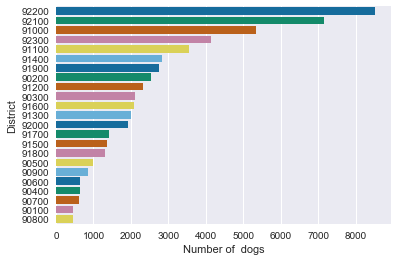

In [21]:
district_dogs = data.groupby('District')['Dog Count'].aggregate(np.sum)
# Filter, sort and trim pandas Series
top_dogs = district_dogs.sort_values(ascending=False)
# Plot pandas Series
ax = sns.barplot(palette='colorblind', y=list(top_dogs.index), x=top_dogs.values, orient='h', order=list(top_dogs.index))
ax.set(ylabel='District', xlabel='Number of  dogs')

OK. 22nd and 21st district of Vienna are the most rich in dogs (8,5 and 7 thousands respectively). 10th, 23rd and 11th districts follow in the dog ranking. 

There are fewer dogs in 1st and 8th districts of Vienna (also, 4th, 6th and 7th).

What could be the possible reasons for such variation in the number of dogs in different districts of Vienna (500-8,500 dogs per district)? We shall need more data to understand this...

### 4. Open Data for Local Communities

Let us analyse district statistics on the example of the 2nd district (Leopoldstadt). 

You can replace the district code in the variable below to see the stats for your own district.

In [22]:
district = 90200
district_dogs[district]


2545

2545 dogs live in Leopoldstadt. 

Is it many or not? Let us compare it with the average number of dogs across all districts of Vienna.

In [23]:
district_dogs.describe()

count      23.000000
mean     2431.695652
std      2111.114019
min       459.000000
25%       922.000000
50%      1990.000000
75%      2787.000000
max      8504.000000
Name: Dog Count, dtype: float64

It is indeed very close to the average number of dogs per Vienna district. Let us see what are the most common breeds in Leopoldstadt.

[<matplotlib.text.Text at 0x115426160>, <matplotlib.text.Text at 0x115473630>]

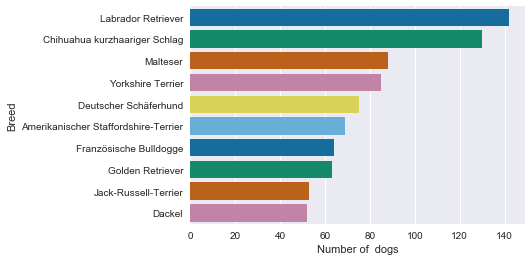

In [24]:
dogs_district = filtered_dogs.loc[(data['District']==district)][['Dog Breed', 'Dog Count']]
top_dogs_district = dogs_district.sort_values(ascending=False, by='Dog Count')[:10]
ax = sns.barplot(data=top_dogs_district,palette='colorblind', x='Dog Count', y='Dog Breed')
ax.set(ylabel='Breed', xlabel='Number of  dogs')

## Lessons Learned

### Dogs in Vienna

Based on the data available we were able to provide comprehensive answers to the set of research questions proposed in the introduction.

1. There are almost 56 thousand dogs in Vienna of 320 different breeds.
2. Labradors and Chihuahuas are the top choices of Viennese people.
3. If you do not like dogs you might want to live in the 1st or 8th districts, where there are fewer dogs (everyone wants to live in the 1st or 8th districts anyway!)
4. Leopoldstadt has an average number of dogs (2,545).
    
### Steps
    1. Find datasets, e.g. CSV files from open data portals
    2. Refine: identify column separator, thousands separator, rows to skip, string encoding, etc.
    3. Slice: filter out rows, e.g. by district or type.
    4. Sort data by count (visualize ranking as a barplot).
    5. Aggregate: group by different attributes, e.g. district or type, and sum up the counts.
 
    
## Prerequisites

To run this script on a local machine you need: 

* Python 3.4.
* pandas
* numpy
* seaborn (pip install)


## Inspired by
1. [Detail Analysis of various Hospital factors](https://www.kaggle.com/nirajvermafcb/d/cms/hospital-general-information/detail-analysis-of-various-hospital-factors)
2. Wheelan, Charles J. Naked Statistics. 2013